<a href="https://colab.research.google.com/github/mantissa-aidan/BCI-Product/blob/master/Neuroprosthetic_Alert_System_(BCI_Nurse_Call_Device).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#something like

%cd /content/drive/My Drive/DATA3888

/content/drive/My Drive/DATA3888


# Neuroprosthetic Alert System (BCI Nurse Call Device)



Brain-Computer Interfaces (BCI) enable signals from the human brain to be communicated to a machine in a way that specific signals would translate to a command which the machine is then meant to carry out. Research in BCI have been taking place since the 1970s and its main focus has been on developing neuroprosthetics applications to benefit those with physical disabilities [1]. At present the BCI devices that have been developed require conscious effort to be controlled. However the aim of research in this field is to develop applications that can be controlled by humans effortlessly. Correspondingly, the main aim of this project is to develop a product that depends on eye-movement signals to seamlessly carry out a practical application.
 
This report specifically focuses on the development of a nurse call device using eye-movement signals in real-time. With many developments in the health sector geared towards people with physical disabilities, one recent improvement of the nurse-call button in hospitals, has been a device which can recognise from a patient’s speech if he/she is calling the nurse and then notify a nurse accordingly[2]. While such a device is ideal for those with physical disabilities, it excludes those who may have speech impediments. Taking this into consideration, the product introduced in this report is geared towards those for whom eye-movement may be the main form of communication.
 
The main issues in regards to developing such a product are the following:
1.     Conducting the relevant physiological measurements and collecting the data accurately
2.     Recognising when a measurement/physiological data corresponds to a specific practical command in real-time.
 
The first issue deals with the problem of data collection. This project made use of an Arduino from Backyard Brains which collected eye-movement signals. While collecting eye-movement data from a person is not too difficult various considerations need to be made when using this data to build a product that can be generally used to carry out tasks. Firstly, the product should be able to correctly identify when a person is making a left or right eye-movement, for example, even when the data collected is quite noisy. This necessitates effective data preprocessing. Secondly, the product should be able to recognise left and right eye-movement for different people. This requires the product to be trained on, and thereby requires the collection of, a large and diverse dataset.

<center>
<img src="https://i.ytimg.com/vi/LYcITvxYB1I/hqdefault.jpg" alt="BYB Spikerbox" width=450/>
</center>

The second issue deals with building a classifier that is able to not only accurately predict what type of eye-movement a certain incoming signal corresponds to, but also do this fast enough in real-time for its practical function to be effective. In this particular project, therefore, a classifier needed to be built that could recognise if a patient made a specific eye-movement sequence that translates to the command to call a nurse. The classifier would need to recognise this accurately and quickly so that the notification can be sent to the nurse in time. 

Below are the details of how the above two issues were addressed in this project. 



In [2]:
#@title BCI NURSE CALL DEVICE

In [4]:

from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
bigdata = pd.read_csv("raw_samples.txt", sep=",")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


FileNotFoundError: ignored

#Data Collection and Preprocessing

The data used to train the classifier used in this project were collected using the arduino interfaced with Python. Electrodes were placed on the forehead and temple of the user and these detected the corneo-retinal standing potential between front and back of the eye, indicating whether the person moved their eyes left or right. The signals incoming from the user was recorded in one second recordings and about 130 recordings were collected for each of left movements, right movements, and no movement. As the data was being recorded, a Fourier transform was applied to denoise the signals. These enabled better recognition of the features corresponding to a left or right eye movement. Each of the recordings were then labeled by hand to avoid incorrect labeling and were combined into one dataset to be used to build different classifiers of the eye-movement. 

Effectively collecting data for this project was dependent on first implementing the real time stream of data from the BYB Spikerbox. It was important to ensure that the data we were using for development would be as close as possible to the data we would classify on deployment. Therefore before we trained any models. We needed data that was filtered using our FT denoising, centred around zero and subset to a prediction window that we chose.

Since the BYB Spikerbox had a sampling rate of 10kHz, we chose a 9990 step window of observations to predict, as this corresponded to a time series of just under 1 second of eye movement data. We then refreshed this window every 1/10th of a second which gave us a rolling window 1 second window of data:

###Visualisation of data stream

<center>
<img src="https://drive.google.com/uc?id=1_HDOKHHc8u-ND0p3Cl57R78KiEZI-q2t" alt="Data stream" width=450/>
</center>

We were provided with R code that split and labelled the recordings based on the zero crossing of the waveform and expected we could implement this into our model testing development. However this code was incompatible with our workflow for the following reasons.

1.   The code was written in R and used the R tsfeatures package which has no implementation in Python, so it could not be implemented into our existing code base.

2.   The code split and labelled WAV files which were recorded through the BYB Spikerbox software. When the BYB Spikerbox recorded and saved data, it downsampled these recordings using a method that was not documented. As a result there was a significant difference between training data created using Spikerbox WAV files and real-time data being streamed in using a Python/numpy implementation.

3.  The code used a zero crossing method of splitting and labelling the data. We tested this labelled data on two-class versions of the same classification models we implemented later in the project. We consistenly found no greater than 52% accuracy using this labelling method on our own recordings which we verfied with cross validation. When we inspected the labelling, we saw that this code had incorrectly labelled left/right movements.

As a result of these issues we had to recreate an entirely new dataset, we simply saved the contents of our realtime rolling window (post filtering and centering) as text files and labelled them by visual inspection.

#Model Development

##Workflow 

The model development process was an iterative one represented by the diagram below. 
<center>
<img src="https://drive.google.com/uc?id=1kSQDZlsAvOsZITig365emIzu4-aaWJxG" alt="Data stream" width=450/>
</center>

During the first iteration of data collection and model building, around 60 samples were recorded for left, right no eye movement each. These recordings were then labelled using the zero-crossing method on R. These labeled samples were then used as training data to build a preliminary keras neural network on R and the in-sample and out-of-sample accuracy. While the in-sample accuracy was found to be 7% while the out-of-sample accuracy was 52.2%. This low prediction accuracy necessitated reviewing the labelling of the training data and it was found that many of the recordings had been labeled incorrectly and it was decided that this was due to presence of noise in the data and due to errors in the design of the zero-crossing labeling method. 

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages('tsfeatures')

In [ ]:
#@title R code for initial Neural Network classifier
%%R
mydir <- list.files("LEFT_scaled", recursive=TRUE, full.names=TRUE)

signals_list_left <- list()

for(i in 1: length(mydir)){
  txtfile<- read.table(mydir[i], header = TRUE, sep = "\t", dec = ".")
  txtfile$x <- as.character(txtfile$x)
  lst <- strsplit(txtfile$x," ")
  list <- as.numeric(sapply(lst, '[[', 2) )
  signals_list_left <- c(signals_list_left, list(list))
}

left_labels <- rep("L",length(mydir))

mydir_right <- list.files("RIGHT_scaled", recursive=TRUE, full.names=TRUE)

signals_list_right <- list()

for(i in 1: length(mydir_right)){
  txtfile<- read.table(mydir_right[i], header = TRUE, sep = "\t", dec = ".")
  txtfile$x <- as.character(txtfile$x)
  lst <- strsplit(txtfile$x," ")
  list <- as.numeric(sapply(lst, '[[', 2) )
  signals_list_right <- c(signals_list_right, list(list))
}

right_labels <- rep("R",length(mydir_right))

Y_list1 <- c()
Y_labels <- c()
Y_list1 <- c(signals_list_left, signals_list_right)
Y_labels <- c(left_labels, right_labels)

Y_labels[c(1,3)]
set.seed(111)
indexes <- sample(length(Y_list1))
length(indexes)
#Y_data<- Y_data[sample(nrow(Y_data)),]
Y_list1 <- Y_list1[indexes]
Y_labels <- Y_labels[indexes]
library(tsfeatures)
Y2_features <- cbind(tsfeatures(Y_list1, c("acf_features", "entropy", "lumpiness", 
    "flat_spots", "crossing_points")), tsfeatures(Y_list1, "max_kl_shift", width = 48), 
    tsfeatures(Y_list1, c("mean", "var"), scale = FALSE, na.rm = TRUE), tsfeatures(Y_list1, 
        c("max_level_shift", "max_var_shift"), trim = TRUE))

Y2_features$class <- c(as.character(Y_labels))
train_idx <- sample(nrow(Y2_features), round(0.8 * nrow(Y2_features)))

X_train <- as.matrix((Y2_features[train_idx, 1:18]))
y_train <- as.numeric(as.factor(Y2_features[train_idx, 19]))

X_test <- as.matrix((Y2_features[-train_idx, 1:18]))
y_test <- as.numeric(as.factor(Y2_features[-train_idx, 19]))


range01 <- function(x) {
    (x - min(x))/(max(x) - min(x))
}
X_train <- apply(X_train, 2, range01)
X_test <- apply(X_test, 2, range01)



model <- keras_model_sequential()
model %>% layer_dense(units = 256, activation = "relu", input_shape = c(18)) %>% 
    layer_dense(units = 64, activation = "relu") %>% layer_dense(units = 10, 
    activation = "softmax")

model %>% compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer_rmsprop(), 
    metrics = c("accuracy"))

model_fit <- model %>% fit(X_train, y_train, epochs = 30, batch_size = 10, validation_split = 0.2)
model %>% evaluate(X_train, y_train)
model %>% evaluate(X_test, y_test)


/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff

  warnings.warn(x, RRuntimeWarning)



Error in keras_model_sequential() : 
  could not find function "keras_model_sequential"


/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in keras_model_sequential() : 
  could not find function "keras_model_sequential"

  warnings.warn(x, RRuntimeWarning)


In the second iteration the filter (that makes use of the Fourier transform) was revised its denoising performance was found to have greatly improved. This training data was then labeled by hand and was used to build multiple classifiers. The accuracy of these were calculated through k-fold cross-validation. 

#Building Classifiers (include cross-validation results)

###Neural Network without feature extraction

This was the application of the artificial neural network algorithm from the Keras package. The dataset was randomised then split into training and testing data of size 90% and 10% respectively and 2 hidden layers were constructed with 150 and 10 neurons in each hidden layer. This model architecture produced accuracy of 85.6% when predictions were made on the testing set. 

The number of hyperparameters such as the number of layers/neurons were changed around to observe its effect on validation accuracy. It was found that there was little difference between the validation accuracy of different combinations of hyperparameters. 


In [6]:
#@title Code
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

y = pd.get_dummies(bigdata['class'])
X = bigdata.drop(['class'], axis = 1)
X = X.drop(['Unnamed: 0'], axis = 1)
# Split the dataset to trainand test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1,random_state=0)

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')
# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(train_X, train_y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(test_X, test_y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 150/150
24/24 [==============================] - 0s 1ms/step
Accuracy: 85.89


###K-Nearest Neighbours

Using the same method of splitting of the dataset into training and testing sets as described above, the KNeighborsClassifier from the scikit learn package was also applied. Various values for the number of neighbours parameter were used and it was found that the highest validation accuracy that could be obtained was 81.8%. Among the neighbour numbers that produced this accuracy, one value was 5. Thus this was the value of the n_neighbors parameter that was used for the purposes of reporting results in this report. 


In [ ]:
#@title Code
y = bigdata['class']
X = bigdata.drop(['class'], axis = 1)
X = X.drop(['Unnamed: 0'], axis = 1)
# Split the dataset to trainand test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1,random_state=0)
from sklearn.neighbors import KNeighborsClassifier
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
#Train the model using the training sets
knn.fit(train_X, train_y)
#Predict the response for test dataset
y_pred = knn.predict(test_X)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))

Accuracy: 0.6666666666666666


###Random Forest (without feature extraction)

Splitting the dataset into training and testing sets of 9:1 ratio again, a Random Forest classifier was built using the scikit learn package in Python. The number of trees in the forest was varied to observe the corresponding variations in validation accuracy. The validation accuracy found to little variation for different number of trees and the highest accuracy was found to be 86.4% given by a model with 10 000 trees. 

In [ ]:
#@title Code
RF = RandomForestClassifier(n_estimators=10000, max_depth=10, random_state=0).fit(train_X, train_y)
RF.predict(test_X)
round(RF.score(test_X, test_y), 4)

0.75

###Feature extraction using tsfresh

From the above it can be observed that the GRU neural network had the best performance accuracy, however since performance is factor in our application we chose to use the random-forest model as it has faster runtime prediction.

We settled on a multi-class classification model that could detected if a movement was "Left', 'Right' or 'Neither'.

In an attempt to improve the model, we decided to use an automatic time series feature extraction package called `tsfresh` that we had found. `tsfresh` can be configured to compute a large number of features, select only those that are statistically signficant for a classification task and return a data frame of those calculated features.

Since we found that a Random Forest model produced the best accuracy method, we furthertested its performance on a range of different features produced by tsfresh and verified the robustness of the model using 20-fold cross validation.

We compared the cross-validation results for models created using three types of feature extraction of the tsfresh package. The first model uses no feature extraction, the second model uses 'Minimal Feature Extraction' and the last model uses 'Efficient Feature Extraction'. While the minimal feature extraction extracts simple features such as minimum value, mean and median, the efficient feature extraction selects 1000 features which are the most statistically significant with regard to influencing a classifier. The code for each cross-validation is shown below. 

###Random Forest with tsfresh

In [ ]:
#@title Code - No Feature Extraction
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM, GRU
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
import pandas as pd
raw_samples  = pd.read_csv("raw_samples.txt", index_col = 0)
raw_samples

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9951,9952,9953,9954,9955,9956,9957,9958,9959,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,class
FT_samples/left/signal.out105,-0.138383,-0.273093,-0.407333,-0.541104,-0.674404,-0.807233,-0.939592,-1.071480,-1.202897,-1.333842,-1.464316,-1.594318,-1.723847,-1.852905,-1.981490,-2.109603,-2.237243,-2.364411,-2.491106,-2.617328,-2.743077,-2.868353,-2.993156,-3.117485,-3.241342,-3.364726,-3.487636,-3.610074,-3.732038,-3.853529,-3.974548,-4.095093,-4.215166,-4.334766,-4.453893,-4.572548,-4.690731,-4.808441,-4.925679,-5.042446,...,5.630209,5.477098,5.324434,5.172219,5.020453,4.869137,4.718272,4.567858,4.417897,4.268388,4.119333,3.970733,3.822587,3.674897,3.527664,3.380887,3.234568,3.088707,2.943305,2.798363,2.653880,2.509858,2.366298,2.223198,2.080561,1.938387,1.796676,1.655429,1.514646,1.374328,1.234474,1.095087,0.956165,0.817710,0.679722,0.542201,0.405147,0.268562,0.132445,0
FT_samples/left/signal.out13,-15.727242,-15.693789,-15.660584,-15.627625,-15.594914,-15.562451,-15.530236,-15.498269,-15.466550,-15.435080,-15.403857,-15.372884,-15.342158,-15.311682,-15.281454,-15.251475,-15.221745,-15.192263,-15.163030,-15.134046,-15.105311,-15.076824,-15.048586,-15.020597,-14.992856,-14.965363,-14.938119,-14.911123,-14.884374,-14.857874,-14.831621,-14.805616,-14.779858,-14.754348,-14.729084,-14.704067,-14.679296,-14.654772,-14.630493,-14.606461,...,-17.220900,-17.178121,-17.135569,-17.093247,-17.051153,-17.009290,-16.967658,-16.926258,-16.885090,-16.844155,-16.803453,-16.762987,-16.722755,-16.682758,-16.642998,-16.603475,-16.564189,-16.525141,-16.486331,-16.447760,-16.409429,-16.371339,-16.333488,-16.295879,-16.258511,-16.221385,-16.184501,-16.147861,-16.111463,-16.075309,-16.039399,-16.003733,-15.968312,-15.933136,-15.898206,-15.863521,-15.829081,-15.794888,-15.760942,0
FT_samples/left/signal.out178,9.991873,9.988105,9.984327,9.980541,9.976745,9.972942,9.969130,9.965310,9.961481,9.957645,9.953801,9.949949,9.946090,9.942223,9.938349,9.934467,9.930579,9.926684,9.922782,9.918874,9.914959,9.911038,9.907111,9.903178,9.899239,9.895295,9.891344,9.887389,9.883429,9.879463,9.875492,9.871517,9.867538,9.863553,9.859565,9.855573,9.851576,9.847576,9.843573,9.839566,...,10.134058,10.130732,10.127393,10.124041,10.120677,10.117300,10.113911,10.110510,10.107096,10.103670,10.100232,10.096781,10.093319,10.089845,10.086359,10.082861,10.079352,10.075830,10.072298,10.068754,10.065199,10.061632,10.058055,10.054466,10.050866,10.047256,10.043635,10.040003,10.036361,10.032708,10.029045,10.025372,10.021689,10.017996,10.014292,10.010580,10.006857,10.003125,9.999384,0
FT_samples/left/signal.out106,48.399120,48.360541,48.321152,48.280958,48.239963,48.198169,48.155582,48.112203,48.068039,48.023092,47.977366,47.930866,47.883595,47.835558,47.786758,47.737200,47.686887,47.635825,47.584017,47.531467,47.478181,47.424161,47.369412,47.313940,47.257747,47.200839,47.143220,47.084895,47.025867,46.966142,46.905724,46.844618,46.782828,46.720359,46.657215,46.593402,46.528924,46.463785,46.397991,46.331547,...,49.241001,49.237374,49.232824,49.227351,49.220957,49.213646,49.205419,49.196279,49.186227,49.175266,49.163398,49.150625,49.136951,49.122377,49.106907,49.090541,49.073285,49.055138,49.036106,49.016190,48.995393,48.973717,48.951167,48.927744,48.903452,48.878294,48.852272,48.825390,48.797651,48.769058,48.739614,48.709323,48.678188,48.646211,48.613397,48.579749,48.545271,48.509965,48.473835,0
FT_samples/left/signal.out15,39.197015,39.025664,38.854437,38.683337,38.512367,38.341531,38.170831,38.000271,37.829854,37.659583,37.489463,37.319495,37.149683,36.980031,36.810541,36.641216,36.472061,36.303077,36.134269,35.965639,35.797190,35.628926,35.460850,35.292964,35.125272,34.957777,34.790482,34.623389,34.456503,34.289826,34.123361,33.957111,33.791078,33.625267,33.459680,33.

In [ ]:

X_raw = raw_samples.drop(["class"], axis = 1)
y_raw = raw_samples["class"]

In [ ]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 10000, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 8,
              'max_leaf_nodes': None}

RF_model = RandomForestClassifier(**parameters)

In [ ]:
import numpy as np

cv_steps = 20

raw_acc_array = np.empty(cv_steps)

for i in range(cv_steps):
    print("cv", i + 1, "of", cv_steps)
    train_X, test_X, train_y, test_y = train_test_split(X_raw, y_raw, test_size=0.1, random_state=i, shuffle = True)
    
    RF_model.fit(train_X, train_y)
    
    RF_predictions = RF_model.predict(test_X)
    acc_score = accuracy_score(test_y ,RF_predictions)
    print(acc_score)

    raw_acc_array[i] = acc_score

cv 1 of 20
0.75
cv 2 of 20
0.6666666666666666
cv 3 of 20
0.7083333333333334
cv 4 of 20
0.6666666666666666
cv 5 of 20
0.8333333333333334
cv 6 of 20
0.6666666666666666
cv 7 of 20
0.75
cv 8 of 20
0.5833333333333334
cv 9 of 20
0.5416666666666666
cv 10 of 20
0.5833333333333334
cv 11 of 20
0.75
cv 12 of 20
0.75
cv 13 of 20
0.6666666666666666
cv 14 of 20
0.7916666666666666
cv 15 of 20
0.7083333333333334
cv 16 of 20
0.8333333333333334
cv 17 of 20
0.75
cv 18 of 20
0.7083333333333334
cv 19 of 20
0.625
cv 20 of 20
0.7916666666666666


In [ ]:
#@title Code - Minimal Feature Extraction
minimal_features  = pd.read_csv("Minimal_features.txt", index_col = 0)
minimal_features

,value__minimum,value__mean,value__sum_values,value__standard_deviation,value__variance,value__maximum,value__median
id,,,,,,,
FT_samples/left/signal.out105,-24.700601,4.401402,43970.003204,28.503879,812.471117,117.805846,-4.374364
FT_samples/left/signal.out106,-25.773813,7.649105,76414.563114,29.193047,852.233975,117.810076,-3.349600
FT_samples/left/signal.out13,-36.809364,-6.112428,-61063.151141,8.830963,77.985906,1.448130,-3.076705
FT_samples/left/signal.out14,-36.075002,-4.846627,-48417.804058,9.165379,84.004177,16.249690,-1.980599
FT_samples/left/signal.out15,-36.075002,4.513028,45085.146126,23.977513,574.921120,87.543441,-0.340329
...,...,...,...,...,...,...,...
FT_samples/right/signal5 (1).out71,-9.480906,4.287666,42833.781579,10.986216,120.696939,35.028874,-1.497082
FT_samples/right/signal5 (1).out72,-9.480906,4.564550,45599.857737,10.727971,115.089364,35.028874,-0.970918
FT_samples/right/signal5 (1).out73,-9.480809,4.719019,47142.995068,10.590190,112.152122,35.028874,0.089503


In [ ]:
import numpy as np

cv_steps = 20

min_acc_array = np.empty(cv_steps)

for i in range(cv_steps):
    print("cv", i + 1, "of", cv_steps)
    train_X, test_X, train_y, test_y = train_test_split(minimal_features, y_raw, test_size=0.1, random_state=i, shuffle = True)
    
    RF_model.fit(train_X, train_y)
    
    RF_predictions = RF_model.predict(test_X)
    acc_score = accuracy_score(test_y ,RF_predictions)
    print(acc_score)

    min_acc_array[i] = acc_score

cv 1 of 20
0.9166666666666666
cv 2 of 20
0.875
cv 3 of 20
0.9166666666666666
cv 4 of 20
0.875
cv 5 of 20
0.8333333333333334
cv 6 of 20
0.9166666666666666
cv 7 of 20
0.875
cv 8 of 20
0.875
cv 9 of 20
0.7916666666666666
cv 10 of 20
0.6666666666666666
cv 11 of 20
0.9166666666666666
cv 12 of 20
0.9583333333333334
cv 13 of 20
0.9583333333333334
cv 14 of 20
0.9166666666666666
cv 15 of 20
0.9583333333333334
cv 16 of 20
0.9583333333333334
cv 17 of 20
0.8333333333333334
cv 18 of 20
0.875
cv 19 of 20
0.7916666666666666
cv 20 of 20
0.8333333333333334


In [ ]:
#@title Code - Efficient Feature Extraction
efficient_features  = pd.read_csv("Efficient_features.txt", index_col = 0)
efficient_features

,"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0","value__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.0","value__change_quantiles__f_agg_""var""__isabs_False__qh_0.2__ql_0.0","value__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","value__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0","value__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.0","value__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.0","value__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.0","value__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.0","value__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2",value__minimum,"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","value__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0","value__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","value__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0",value__quantile__q_0.1,value__skewness,"value__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2","value__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0","value__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","value__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.2",value__c3__lag_3,value__c3__lag_2,value__c3__lag_1,value__longest_strike_above_mean,value__count_below_mean,value__count_above_mean,"value__fft_coefficient__coeff_7__attr_""abs""","value__fft_coefficient__coeff_80__attr_""abs""","value__fft_coefficient__coeff_68__attr_""abs""","value__fft_coefficient__coeff_6__attr_""abs""",value__quantile__q_0.2,"value__augmented_dickey_fuller__attr_""teststat""","value__augmented_dickey_fuller__attr_""pvalue""",value__mean,value__sum_values,"value__fft_coefficient__coeff_0__attr_""real""","value__fft_coefficient__coeff_98__attr_""abs""","value__fft_coefficient__coeff_13__attr_""abs""","value__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""stderr""",...,value__number_peaks__n_3,"value__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2","value__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4","value__fft_coefficient__coeff_15__attr_""abs""",value__quantile__q_0.7,value__symmetry_looking__r_0.05,"value__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","value__fft_coefficient__coeff_18__attr_""abs""",value__partial_autocorrelation__lag_9,value__energy_ratio_by_chunks__num_segments_10__segment_focus_9,value__partial_autocorrelation__lag_6,value__partial_autocorrelation__lag_8,value__partial_autocorrelation__lag_7,value__cid_ce__normalize_True,value__number_crossing_m__m_-1,"value__fft_coefficient__coeff_20__attr_""abs""","value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""intercept""","value__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""","value__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2",value__autocorrelation__lag_9,value__max_langevin_fixed_point__m_3__r_30,value__autocorrelation__lag_8,"value__fft_coefficient__coeff_26__attr_""abs""",value__autocorrelation__lag_7,"value__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4",value__autocorrelation__lag_6,"value__fft_aggregated__aggtype_""kurtosis""",value__autocorrelation__lag_5,value__autocorrelation__lag_4,value__autocorrelation__lag_3,"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",value__autocorrelation__lag_2,"value__fft_aggregated__aggtype_""skew""",value__autocorrelation__lag_1,value__partial_autocorrelation__lag_1,"value__fft_coefficient__coeff_27__attr_""abs""","value__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4"
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FT_samples/left/signal.out105,0.000

In [ ]:
import numpy as np

cv_steps = 20

eff_acc_array = np.empty(cv_steps)

for i in range(cv_steps):
    print("cv", i + 1, "of", cv_steps)
    train_X, test_X, train_y, test_y = train_test_split(efficient_features, y_raw, test_size=0.1, random_state=i, shuffle = True)
    
    RF_model.fit(train_X, train_y)
    
    RF_predictions = RF_model.predict(test_X)
    acc_score = accuracy_score(test_y ,RF_predictions)
    print(acc_score)

    eff_acc_array[i] = acc_score

cv 1 of 20
0.9166666666666666
cv 2 of 20
0.9583333333333334
cv 3 of 20
0.875
cv 4 of 20
0.9583333333333334
cv 5 of 20
0.875
cv 6 of 20
0.8333333333333334
cv 7 of 20
0.875
cv 8 of 20
0.8333333333333334
cv 9 of 20
0.8333333333333334
cv 10 of 20
0.7083333333333334
cv 11 of 20
0.9583333333333334
cv 12 of 20
0.9166666666666666
cv 13 of 20
0.875
cv 14 of 20
0.9166666666666666
cv 15 of 20
0.9166666666666666
cv 16 of 20
1.0
cv 17 of 20
0.75
cv 18 of 20
0.875
cv 19 of 20
0.875
cv 20 of 20
0.8333333333333334


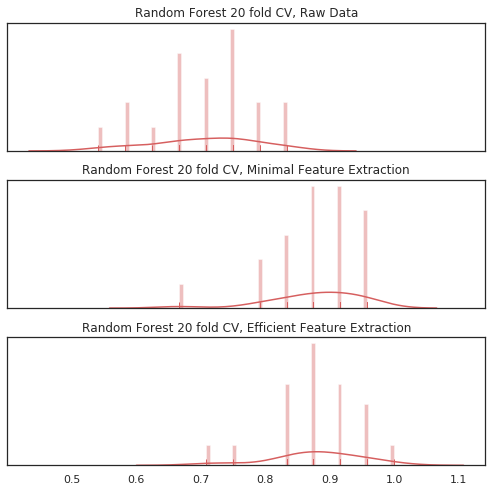

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)
axes[0].set_title("Random Forest 20 fold CV, Raw Data")
axes[1].set_title("Random Forest 20 fold CV, Minimal Feature Extraction")
axes[2].set_title("Random Forest 20 fold CV, Efficient Feature Extraction")
sns.distplot(raw_acc_array, hist=True, rug=True, bins = 50, color="r", ax=axes[0])
sns.distplot(min_acc_array, hist=True, rug=True, bins = 50, color="r", ax=axes[1])
sns.distplot(eff_acc_array, hist=True, rug=True, bins = 50, color="r", ax=axes[2])

plt.setp(axes, yticks=[])
plt.tight_layout()

As it can be seen from above, the model with the Minimal Feature Extraction returns the highest validation accuracy. 

The Efficient Feature method selects 232 calculated features that the package determined were significant. However from the CV results we can see that this does not help improve accuracy we postulate this could be due to the following.

*   A small training set.
*   Not enough variance in samples.
*   The curse of dimensionality that leads us to overfit when we include too many features



# Implementation

>   
*   A hardware API for BYB Spikerbox to read EEG signals.
*   High accuracy real time machine learning classifier.
*   Web enabled dashboard.

Our implementation of our classification model is described with the following algorithm:
 
<center>
<img src="https://drive.google.com/uc?id=1VPZBGGvVxFUkSe857QmXVMAzwLf4ah6L" alt="Algorithm" width=450/>
</center>

Our classifier currently features a 90% prediction accuracy with a refresh rate of ~ 1 second per prediction. The main loop is implemented in Python and primarily uses numpy operations to transform the data. The API reads data from the arduino, which is fed to our classifier which produces a prediction, in the form of a string of characters 'L', 'R', 'N', 'F'. This is then sent to a dashboard which can be customised to detect specific sequences by searching the string using a simple regular expression.

When a sequence is detected a popup and sound notification is sent to the browser to inform the user that a patient has requested assistance.

<center>
<img src="https://drive.google.com/uc?id=1z7n7itcV5lko6e8pVS8d2pFKU8wF8Iu7" alt="Dashboard" width=450/>
</center>

The dashboard was implemented using Node-Red which handles UI and requests from the server. This enables multiple users to few the dashboard on any internet enabled device in real time. The pipeline of data is best described in the following diagram:

<center>
<img src="https://drive.google.com/uc?id=1apM_bzktFcdJ2zk4NjDfM3erZW8Pm6Zo" alt="Product pipeline" width=600/>
</center>

[Can be viewed in higher resolution here](https://drive.google.com/uc?id=1apM_bzktFcdJ2zk4NjDfM3erZW8Pm6Zo)

Although we demonstrated a high level of accuracy when fitting our random forest models, there was sa significant bottleneck in real time feature extraction.

The feature extraction package we used was not intended to be used in real time. We experienced a significant reduction in speed performance of the application when we included mnore features. To account for this we tested a baseline model of a random forest and then added the most useful features iteratively until we found an acceptable middleground between speed and accuracy.

Generating features from a sample in realtime using the tsfeatures package could take up to four minutes for a single prediction, which is completely infeasible. We found the optimal speed and accuracy of the application by using these features:

**value__minimum, value__mean,	value__sum_values,	value__standard_deviation,	value__variance,	value__maximum,	value__median**

Granted these a very simplistic features, but that is a result of their calculations being fast to perform. For further development of this project, we could experiment with custom implementations of important features that are efficiently calculated.

We could also try to predict over a smaller sampling windows as this should increase speed of the application.







#Final Remarks

Overall it can be concluded from this report that given the nature of the training data the random forest with minimal feature extraction using the tsfresh package is best for when optimizing both for prediction accuracy and speed of prediction. With regard to data pre-processing, labelling the data using the method based on zero-crossing of the waveform was not accurate. Rather, hand-labelling the training data was found to produce better validation accuracy for the model built on it and our final product was able to predict the command to call a nurse based on eye-movement sequence with 90% accuracy.
 
The product could nonetheless be improved in the following aspects. A larger training set would possibly allow the more complex models to predict with better accuracy, although hand-labelling these would be time-consuming. The device speed could possibly be improved by optimise the filtering and reducing the number of features extracted although this could possibly hamper the prediction accuracy – thus more research could be done as to how this trade-off can be handled. Lastly, the device can be upgraded such that it is able to support multiple patients at once and that a patient is able to customise the eye-sequence they wish to use to call the nurse. 


#References

1. The Brief History of Brain Computer Interfaces, April 4, 2014, http://www.brainvision.co.uk/blog/2014/04/the-brief-history-of-brain-computer-interfaces/
2. DeloiteASSIST Transforming patient communication through artificial intelligence, https://www2.deloitte.com/nz/en/pages/life-sciences-and-healthcare/articles/deloitte-assist-transforming-patient-communication.html
 